In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import timm
from torch.cuda.amp import autocast, GradScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.amp import GradScaler, autocast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [19]:
# Memory-efficient settings for RTX 3050 Ti
IMG_SIZE = 300            # EfficientNet-B4 recommended input
BATCH_SIZE_HEAD = 32       # Stage 1
BATCH_SIZE_FINE = 16       # Stage 2
EPOCHS_HEAD = 10
EPOCHS_FINE = 5
LR_HEAD = 1e-3
LR_FINE = 1e-4
GRAD_ACCUM_STEPS = 2       # simulate larger batch


In [20]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [21]:
train_dir = r"E:\SKIN 2\skin-disease-datasaet\train_set"
val_dir = r"E:\SKIN 2\skin-disease-datasaet\test_set"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_HEAD, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_HEAD, shuffle=False, num_workers=4, pin_memory=True)


In [22]:
targets = [label for _, label in train_dataset.imgs]
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [23]:
model = timm.create_model("tf_efficientnet_b4.ns_jft_in1k", pretrained=True)

model = model.to(device)


In [24]:
NUM_CLASSES = 8
model = timm.create_model("tf_efficientnet_b4.ns_jft_in1k", pretrained=True)
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, NUM_CLASSES)  # must be before defining criterion
class_weights = torch.tensor([1.0]*NUM_CLASSES).to(device)  # or your custom weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LR_HEAD)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_HEAD)

scaler = GradScaler("cuda")


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# -------------------------------
# CONFIGURATION
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES = 7
GRAD_ACCUM_STEPS = 2  # example, set as you need
EPOCHS_HEAD = 15
LR_HEAD = 1e-4

# -------------------------------
# MODEL (replace classifier for NUM_CLASSES)
# -------------------------------
import timm
model = timm.create_model("tf_efficientnet_b4.ns_jft_in1k", pretrained=True)
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

# -------------------------------
# LOSS, OPTIMIZER, SCHEDULER
# -------------------------------
# class_weights should be length NUM_CLASSES
class_weights = torch.ones(NUM_CLASSES).to(device)  # replace with your weights if needed
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=LR_HEAD)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_HEAD)

# -------------------------------
# AMP Scaler
# -------------------------------
scaler = GradScaler("cuda")

# -------------------------------
# Freeze backbone
# -------------------------------
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

# -------------------------------
# TRAINING LOOP
# -------------------------------
for epoch in range(EPOCHS_HEAD):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()
    
    loop = tqdm(train_loader, desc=f"Head Training Epoch [{epoch+1}/{EPOCHS_HEAD}]")
    
    for i, (images, labels) in enumerate(loop):
        # Move to device and correct dtype
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long().view(-1)
        
        with autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels) / GRAD_ACCUM_STEPS  # scale for gradient accumulation
        
        # Backward with scaler
        scaler.scale(loss).backward()
        
        # Gradient accumulation step
        if (i + 1) % GRAD_ACCUM_STEPS == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Metrics
        running_loss += loss.item() * images.size(0) * GRAD_ACCUM_STEPS
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loop.set_postfix(loss=running_loss/total, acc=100*correct/total)
    
    # Scheduler step
    scheduler.step()
    
    print(f"Epoch [{epoch+1}/{EPOCHS_HEAD}] - Loss: {running_loss/total:.4f}, Accuracy: {100*correct/total:.2f}%")


Head Training Epoch [1/15]: 100%|██████████| 26/26 [00:23<00:00,  1.11it/s, acc=19.4, loss=1.93]


Epoch [1/15] - Loss: 1.9275, Accuracy: 19.39%


Head Training Epoch [2/15]: 100%|██████████| 26/26 [00:20<00:00,  1.27it/s, acc=32.1, loss=1.87]


Epoch [2/15] - Loss: 1.8725, Accuracy: 32.12%


Head Training Epoch [3/15]: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s, acc=40.4, loss=1.83]


Epoch [3/15] - Loss: 1.8314, Accuracy: 40.36%


Head Training Epoch [4/15]: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s, acc=47.3, loss=1.79]


Epoch [4/15] - Loss: 1.7902, Accuracy: 47.27%


Head Training Epoch [5/15]: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s, acc=54.2, loss=1.75]


Epoch [5/15] - Loss: 1.7479, Accuracy: 54.18%


Head Training Epoch [6/15]: 100%|██████████| 26/26 [00:20<00:00,  1.27it/s, acc=57.9, loss=1.72]


Epoch [6/15] - Loss: 1.7229, Accuracy: 57.94%


Head Training Epoch [7/15]: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s, acc=59.8, loss=1.69]


Epoch [7/15] - Loss: 1.6919, Accuracy: 59.76%


Head Training Epoch [8/15]: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s, acc=63.9, loss=1.67]


Epoch [8/15] - Loss: 1.6652, Accuracy: 63.88%


Head Training Epoch [9/15]: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s, acc=66.2, loss=1.64]


Epoch [9/15] - Loss: 1.6417, Accuracy: 66.18%


Head Training Epoch [10/15]: 100%|██████████| 26/26 [00:20<00:00,  1.27it/s, acc=66.8, loss=1.63]


Epoch [10/15] - Loss: 1.6289, Accuracy: 66.79%


Head Training Epoch [11/15]: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s, acc=67.8, loss=1.61]


Epoch [11/15] - Loss: 1.6127, Accuracy: 67.76%


Head Training Epoch [12/15]: 100%|██████████| 26/26 [00:20<00:00,  1.27it/s, acc=66.8, loss=1.62]


Epoch [12/15] - Loss: 1.6177, Accuracy: 66.79%


Head Training Epoch [13/15]: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s, acc=68, loss=1.61]  


Epoch [13/15] - Loss: 1.6060, Accuracy: 68.00%


Head Training Epoch [14/15]: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s, acc=65.9, loss=1.61]


Epoch [14/15] - Loss: 1.6124, Accuracy: 65.94%


Head Training Epoch [15/15]: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s, acc=66.9, loss=1.6] 

Epoch [15/15] - Loss: 1.6009, Accuracy: 66.91%


In [26]:
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
import torch.optim as optim
from tqdm import tqdm

# -------------------------------
# CONFIG
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
BATCH_SIZE_FINE = 16  # reduce for GPU memory
EPOCHS_FINE = 15
LR_FINE = 1e-5
GRAD_ACCUM_STEPS = 2  # adjust as needed

# -------------------------------
# Unfreeze all layers
# -------------------------------
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=LR_FINE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_FINE)

# Use a smaller DataLoader for fine-tuning
fine_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_FINE,
                         shuffle=True, num_workers=4, pin_memory=True)

# AMP scaler (reuse if already defined)
scaler = GradScaler("cuda")

# -------------------------------
# FINE-TUNING LOOP
# -------------------------------
for epoch in range(EPOCHS_FINE):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()
    
    loop = tqdm(fine_loader, desc=f"Fine-Tuning Epoch [{epoch+1}/{EPOCHS_FINE}]")
    
    for i, (images, labels) in enumerate(loop):
        # Move to device and correct dtype
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long().view(-1)
        
        with autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels) / GRAD_ACCUM_STEPS  # scale for gradient accumulation
        
        # Backward with GradScaler
        scaler.scale(loss).backward()
        
        # Gradient accumulation step
        if (i + 1) % GRAD_ACCUM_STEPS == 0 or (i + 1) == len(fine_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Metrics
        running_loss += loss.item() * images.size(0) * GRAD_ACCUM_STEPS
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loop.set_postfix(loss=running_loss/total, acc=100*correct/total)
    
    # Scheduler step
    scheduler.step()
    
    print(f"Epoch [{epoch+1}/{EPOCHS_FINE}] - Loss: {running_loss/total:.4f}, Accuracy: {100*correct/total:.2f}%")


Fine-Tuning Epoch [1/15]: 100%|██████████| 52/52 [01:10<00:00,  1.36s/it, acc=68.4, loss=1.57]


Epoch [1/15] - Loss: 1.5726, Accuracy: 68.36%


Fine-Tuning Epoch [2/15]: 100%|██████████| 52/52 [01:09<00:00,  1.33s/it, acc=73.9, loss=1.48]


Epoch [2/15] - Loss: 1.4758, Accuracy: 73.94%


Fine-Tuning Epoch [3/15]: 100%|██████████| 52/52 [01:09<00:00,  1.33s/it, acc=77.8, loss=1.37]


Epoch [3/15] - Loss: 1.3678, Accuracy: 77.82%


Fine-Tuning Epoch [4/15]: 100%|██████████| 52/52 [01:08<00:00,  1.32s/it, acc=84, loss=1.25]  


Epoch [4/15] - Loss: 1.2454, Accuracy: 84.00%


Fine-Tuning Epoch [5/15]: 100%|██████████| 52/52 [01:08<00:00,  1.33s/it, acc=83.2, loss=1.16]


Epoch [5/15] - Loss: 1.1587, Accuracy: 83.15%


Fine-Tuning Epoch [6/15]: 100%|██████████| 52/52 [01:08<00:00,  1.33s/it, acc=87, loss=1.06]  


Epoch [6/15] - Loss: 1.0587, Accuracy: 87.03%


Fine-Tuning Epoch [7/15]: 100%|██████████| 52/52 [01:08<00:00,  1.32s/it, acc=86.9, loss=0.98] 


Epoch [7/15] - Loss: 0.9805, Accuracy: 86.91%


Fine-Tuning Epoch [8/15]: 100%|██████████| 52/52 [01:08<00:00,  1.32s/it, acc=89.3, loss=0.9]  


Epoch [8/15] - Loss: 0.9000, Accuracy: 89.33%


Fine-Tuning Epoch [9/15]: 100%|██████████| 52/52 [01:08<00:00,  1.32s/it, acc=89.3, loss=0.841]


Epoch [9/15] - Loss: 0.8408, Accuracy: 89.33%


Fine-Tuning Epoch [10/15]: 100%|██████████| 52/52 [01:08<00:00,  1.33s/it, acc=90.8, loss=0.797]


Epoch [10/15] - Loss: 0.7974, Accuracy: 90.79%


Fine-Tuning Epoch [11/15]: 100%|██████████| 52/52 [01:09<00:00,  1.33s/it, acc=90.8, loss=0.762]


Epoch [11/15] - Loss: 0.7622, Accuracy: 90.79%


Fine-Tuning Epoch [12/15]: 100%|██████████| 52/52 [01:09<00:00,  1.34s/it, acc=91, loss=0.741]  


Epoch [12/15] - Loss: 0.7412, Accuracy: 91.03%


Fine-Tuning Epoch [13/15]: 100%|██████████| 52/52 [01:09<00:00,  1.33s/it, acc=90.9, loss=0.733]


Epoch [13/15] - Loss: 0.7327, Accuracy: 90.91%


Fine-Tuning Epoch [14/15]: 100%|██████████| 52/52 [01:08<00:00,  1.33s/it, acc=90.8, loss=0.723]


Epoch [14/15] - Loss: 0.7230, Accuracy: 90.79%


Fine-Tuning Epoch [15/15]: 100%|██████████| 52/52 [01:08<00:00,  1.32s/it, acc=90.9, loss=0.743]

Epoch [15/15] - Loss: 0.7429, Accuracy: 90.91%


In [27]:
torch.save(model.state_dict(), r"E:\SKIN 2\skin_disease_rtx3050ti_weights.pth")
print("Weights-only state_dict saved!")


Weights-only state_dict saved!


In [28]:
def validate_accuracy(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Validation Accuracy: {acc:.2f}%")
    return acc


In [29]:
validate_accuracy(model, val_loader)


Validation Accuracy: 95.22%


95.2153110047847

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

def evaluate_model(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients → saves GPU memory
        for images, labels in val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            preds = model(images)
            preds = torch.argmax(preds, dim=1)

            # Move to CPU immediately to free GPU
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n==== Classification Report ====\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\n==== Confusion Matrix ====\n")
    print(confusion_matrix(all_labels, all_preds))

    return all_labels, all_preds


In [31]:
class_names = train_dataset.classes  # or manually define class list

labels, preds = evaluate_model(model, val_loader, class_names)



==== Classification Report ====

                 precision    recall  f1-score   support

 BA- cellulitis       0.91      0.94      0.93        34
    BA-impetigo       1.00      1.00      1.00        20
FU-athlete-foot       1.00      1.00      1.00        32
 FU-nail-fungus       0.94      1.00      0.97        33
    FU-ringworm       1.00      0.78      0.88        23
  VI-chickenpox       0.97      0.94      0.96        34
    VI-shingles       0.89      0.97      0.93        33

       accuracy                           0.95       209
      macro avg       0.96      0.95      0.95       209
   weighted avg       0.95      0.95      0.95       209


==== Confusion Matrix ====

[[32  0  0  1  0  0  1]
 [ 0 20  0  0  0  0  0]
 [ 0  0 32  0  0  0  0]
 [ 0  0  0 33  0  0  0]
 [ 3  0  0  0 18  1  1]
 [ 0  0  0  0  0 32  2]
 [ 0  0  0  1  0  0 32]]


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


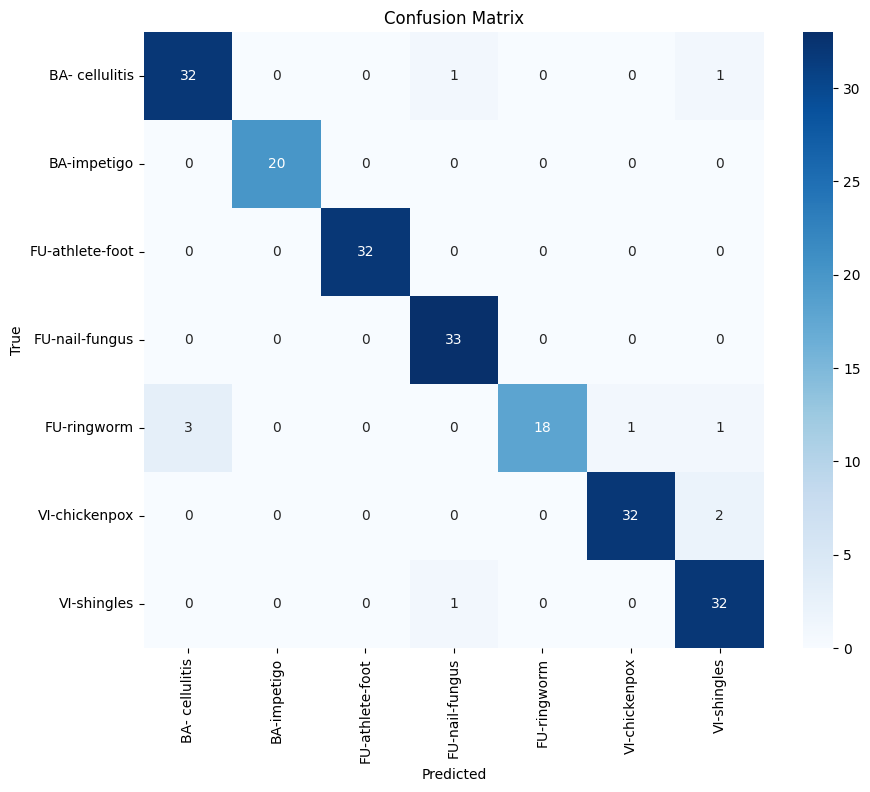

In [33]:
plot_confusion_matrix(labels, preds, class_names)


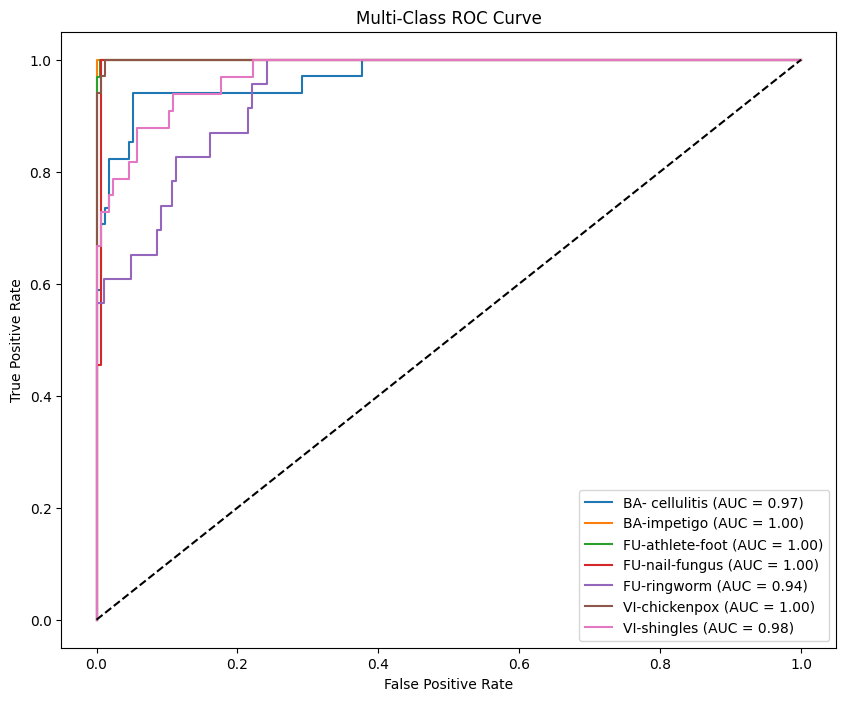

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

def plot_multiclass_roc(model, val_loader, class_names):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)

            y_true.extend(labels.cpu().numpy())
            y_score.extend(outputs.cpu().numpy())  # logits to CPU

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    y_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    plt.figure(figsize=(10, 8))

    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend()
    plt.show()
plot_multiclass_roc(model, val_loader, class_names)
